In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm

In [3]:
data = pd.read_csv("depression_dataset_reddit_cleaned.csv")
data.rename({'clean_text':'text', 'is_depression':'depression'}, axis='columns', inplace=True)
data

,text,depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1
...,...,...
7726,is that snow,0
7727,moulin rouge mad me cry once again,0
7728,trying to shout but can t find people on the list,0
7729,ughh can t find my red sox hat got ta wear thi...,0


In [4]:
data.dtypes

text          object
depression     int64
dtype: object

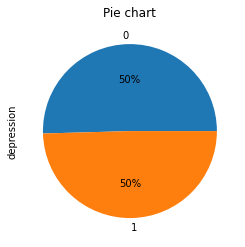

In [5]:
# see data distributions
count_Class = pd.value_counts(data["depression"], sort= True)
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.show()

In [6]:
count1 = Counter(" ".join(data[data['depression']==0]["text"]).split()).most_common(30)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(data[data['depression']==1]["text"]).split()).most_common(30)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

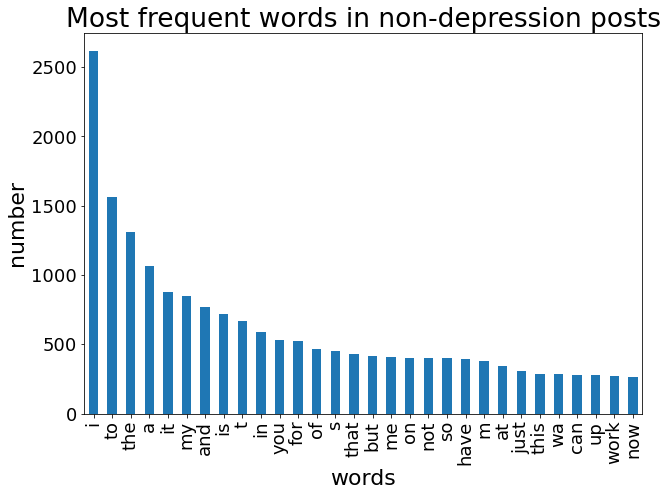

In [28]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.rcParams["figure.figsize"]=10,7
plt.rcParams["font.size"]=22
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('Most frequent words in non-depression posts')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

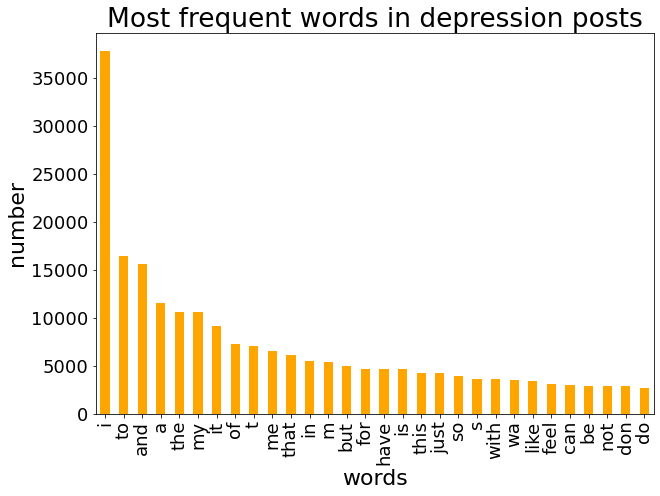

In [27]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.rcParams["figure.figsize"]=10,7
plt.rcParams["font.size"]=22
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.xticks(y_pos, df2["words in spam"])
plt.title('Most frequent words in depression posts')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

In [29]:
from sklearn.feature_extraction import text
# remove stop words (and some extras floating letters because the cleaned dataset got rid of punctuations)
# tokenize each text block and get a matrix of token count
stop_words = text.ENGLISH_STOP_WORDS.union("wa", "didn","t", "m", "s", "don", "ve")
f = feature_extraction.text.CountVectorizer(stop_words=stop_words)
X = f.fit_transform(data['text'])
np.shape(X)

(7731, 18529)

In [208]:
# randomly split into training dataset (80%) and test dataset (20%)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['depression'], test_size=0.2, random_state=42)
# randomly split the training dataset into training (60%) and validation dataset (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## Naive Bayes

In [209]:
# Multinomial NB of sklearn have alpha value to handle words that does not exist in the training dataset
# Similar to SVM, I just plug in various alpha values to train then determine which model is the most robust
list_alpha = np.arange(0.01, 20, 0.10)
score_train = np.zeros(len(list_alpha))
score_val = np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_val[count]= bayes.score(X_val, y_val)
    count = count + 1 

In [210]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_val])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Validation Accuracy'])
models.head(n=10)

,alpha,Train Accuracy,Validation Accuracy
0,0.01,0.982104,0.893273
1,0.11,0.978008,0.902329
2,0.21,0.972833,0.898448
3,0.31,0.965071,0.891332
4,0.41,0.959465,0.884864
5,0.51,0.952350,0.878396
6,0.61,0.943079,0.868693
7,0.71,0.934023,0.862225
8,0.81,0.924752,0.853169
9,0.91,0.918068,0.841527


In [211]:
# choose the model with the highest validation accuracy point (chosen alpha=0.11)
best_index = models['Validation Accuracy'].idxmax()
alpha = models.iloc[best_index, :][0]

In [212]:
# build the model with the chosen alpha value
bayes = naive_bayes.MultinomialNB(alpha=alpha)
bayes.fit(X_train, y_train)
# detailed results when use on test dataset
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
display(pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1']))
print("Correctly identified",(679/(679+104))*100, "% of non-depression posts.")
print("Correctly identified",(736/(28+736))*100, "% of depression posts.")

,Predicted 0,Predicted 1
Actual 0,679,104
Actual 1,28,736


Correctly identified 86.71775223499361 % of non-depression posts.
Correctly identified 96.33507853403141 % of depression posts.


## SVM

In [213]:
# By default, scikit's SVC uses radial basis function (RBF) kernel, C=1.0 and it gave really good results
# so I just test different C values to see if it can get any better
list_C = np.arange(1, 100, 10)
score_train = np.zeros(len(list_C))
score_val = np.zeros(len(list_C))
count = 0
# train various models with different Cs then test on the validation dataset
for C in list_C:
    svc = svm.SVC(C=C)
    svc.fit(X_train, y_train)
    score_train[count] = svc.score(X_train, y_train)
    score_val[count]= svc.score(X_val, y_val)
    count = count + 1

In [214]:
# show models' accuracy scores
matrix = np.matrix(np.c_[list_C, score_train, score_val])
models = pd.DataFrame(data = matrix, columns = ['C', 'Train Accuracy', 'Validation Accuracy'])
models.head(n=10)

,C,Train Accuracy,Validation Accuracy
0,1.0,0.966365,0.954722
1,11.0,0.991160,0.967012
2,21.0,0.995257,0.963131
3,31.0,0.995472,0.957956
4,41.0,0.996766,0.956016
5,51.0,0.997413,0.955369
6,61.0,0.997413,0.952135
7,71.0,0.997413,0.949547
8,81.0,0.997844,0.950194
9,91.0,0.998275,0.948254


In [215]:
# choose the model with the highest test accuracy score (the best C=11)
best_index = models['Validation Accuracy'].idxmax()
C = models.iloc[best_index, :][0]

In [216]:
# build the model with the best C value
svc = svm.SVC(C=C)
svc.fit(X_train, y_train)
# show details of the prediction from the chosen model
m_confusion_test = metrics.confusion_matrix(y_test, svc.predict(X_test))
display(pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1']))

# these rates are hard-coded, but they should not change unless you change the random_state values above
print("Correctly identified",(771/(771+12))*100, "% of non-depression posts.")
print("Correctly identified",(705/(59+705))*100, "% of depression posts.")

,Predicted 0,Predicted 1
Actual 0,771,12
Actual 1,59,705


Correctly identified 98.46743295019157 % of non-depression posts.
Correctly identified 92.27748691099477 % of depression posts.
